# Example: convert DHARMA LES 3D output to DEPHY format

Code to read DHARMA LES output files and write to DEPHY format (NetCDF)

Contributed by Florian Tornow Columbia University & NASA/GISS and Ann Fridlind from NASA/GISS

## Import libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import netCDF4
import datetime as dt
from netCDF4 import Dataset
import re
import sys

import pathlib

%run ../plotting/functions_plotting.py
%run function_extract_2d.py 

R_const = 287 #J kg^-1 K^-1

## Specify directory locations

If on the ARM JupyterHub, it is recommended to create and specify a local directory that is outside of the COMBLE-MIP repository to upload raw model output files in your model's format. 

Processed domain-mean outputs are invited for commit to the GitHub repository on a user-specified branch under /comble-mip/output_les/YOUR_MODEL_NAME/sandbox/YOUR_RUN_NAME. These can be committed and removed at any time.

It is requested to name your baseline small-domain run directory as 'Lx25km_dx100m' (in place of YOUR_RUN_NAME), so that it can readily be automatically compared with other runs using the same test specification.

In [2]:
# specify start time of simulation and simulation name
start_dtime = '2020-03-12 22:00:00.0'

# specify input data directory name, traceable to source machine, and
# specify output file name (see file naming convention in TOC)

# ProgNa with ice test
my_readdir = 'case0313_diag_ice25_nomiz_dx100_specZ0_sbhomo'
my_outfile = 'DHARMA_Lx25_dx100_FixN_3D.nc'

my_readdir = 'case0313_prog_ice25_nomiz_dx100_specZ0_redo'
my_outfile = 'DHARMA_Lx25_dx100_ProgNa_3D_10h.nc'

start_dtime = '2020-05-12 13:00:00.0'
my_readdir = 'case0512_prog_ice10_nosub'
my_outfile = 'DHARMA_Lx25_dx100_ProgNa_nosub_3D_29h.nc'

# specify local source directories (additional subdirectories if restart was required)
my_rundir = '/data/home/floriantornow/dharma/sandbox/' + my_readdir + '/'

my_outdirs = sorted([f for f in os.listdir(my_rundir) if not f.startswith('.')], key=str.lower)
print(my_outdirs)

# specify Github scratch directory where processed model output will be committed
my_gitdir = '../../output_les/dharma/sandbox/'

['0-29h']


## Read DHARMA data

### Locate 2D files

In [3]:
## locate all files that have the expected filename (*.tgz)
path = my_rundir + my_outdirs[0]
direc = pathlib.Path(path)
NCFILES = list(direc.rglob("*tgz"))
NCFILES_STR = [str(p) for p in pathlib.Path(path).rglob('*.tgz')]

NCFILES_STR

input_filenames = []
count = 0
for fn in NCFILES: 
    if ('PLT' in NCFILES_STR[count]):
        input_filenames.append(fn)
    count += 1

In [4]:
input_filenames

[PosixPath('/data/home/floriantornow/dharma/sandbox/case0512_prog_ice10_nosub/0-29h/dharma_PLT_041760.tgz')]

### Read 2D files

In [5]:
## obtain model horizontal resolution
cdf_filename = my_rundir + my_outdirs[0] + '/dharma.cdf'
dharma_params = xr.open_dataset(cdf_filename)
print(cdf_filename)

nx = dharma_params['geometry'].nx
Lx = dharma_params['geometry'].L_x

## obtain vertical resolution
nz = dharma_params['geometry'].nz

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


/data/home/floriantornow/dharma/sandbox/case0512_prog_ice10_nosub/0-29h/dharma.cdf


In [6]:
## obtain auxiliary info from sounding file
sound_filename = my_rundir + my_outdirs[0] + '/dharma.soundings.cdf'
dharma_sound = xr.open_dataset(sound_filename)
theta_00 = dharma_sound.theta_00

In [7]:
xy_res = Lx/nx
xy_res

200.0

In [8]:
## read profiles to complete pressure profile
var_vec_1d = ['lwpc'] # variables with ERA5 (longer time axis)
var_vec_2d = ['rhoa','ta','theta']
df_col_1d,df_col_2d = load_sims('../../output_les/',var_vec_1d,var_vec_2d,t_shift=-2,keyword='DHARMA_Lx25_dx100_FixN.')

init_prof = df_col_2d[abs(round(df_col_2d.time)-df_col_2d['time'].min())<2.]

Loading variables: f(time)
../../output_les/dharma/sandbox/DHARMA_Lx25_dx100_FixN.nc
Loading variables: f(time,height)
../../output_les/dharma/sandbox/DHARMA_Lx25_dx100_FixN.nc


In [9]:
## prepare pressure field translation
rhobar = dharma_sound['rhobar'].isel(time=0).values
th_snd = theta_00*(1. + dharma_sound['th'].isel(time=0).values)
T_snd = dharma_sound['T'].isel(time=0).values

pii = T_snd/th_snd
penv_mks = 1e6*pii**(1/0.286)*0.1

In [10]:
time_vec = []

counter = 0
for input_filename in input_filenames[0:1]:
        
    ## also check if partner file ("alt_3d") is available
    input_filename_2 = Path(str(input_filename).replace('PLT', 'alt_3d'))
    
    ## obtain timestamp
    time_vec.append(obtain_time(path,input_filename,type='PLT_'))

    ## ascertain horizontal resolution and prepare horizontal grid
    xy_res = Lx/nx
    x_vec = np.arange(-Lx/2, Lx/2, xy_res)
    y_vec = np.arange(-Lx/2, Lx/2, xy_res)
    z_vec = dharma_sound['zt'].values
        
    ## unpack tgz and extract relevant fields     
    pa_3d  = threed_loader(input_filename,vbase = 'press')
    pa_1d  = (pa_3d.mean(axis=2).mean(axis=1)*rhobar + penv_mks) # Pa
    pa_3d_act = np.tile(penv_mks.reshape(len(penv_mks),1,1),[nx,nx]) + np.tile(rhobar.reshape(len(rhobar),1,1),[nx,nx])*pa_3d # Pa
    
    ua_3d  = threed_loader(input_filename,vbase = 'u') #+ dharma_params['translate'].u
    va_3d  = threed_loader(input_filename,vbase = 'v') #+ dharma_params['translate'].v
    wa_3d  = threed_loader(input_filename,vbase = 'w')
    th_3d  = theta_00*(1. + threed_loader(input_filename,vbase = 'th'))
    ta_3d  = np.tile(pii.reshape(len(pii),1,1),[nx,nx]) * th_3d 
    rhoa_3d = pa_3d_act/ta_3d/R_const
    
    qv_3d   = threed_loader(input_filename,vbase = 'qv')
    qlc_3d  = threed_loader(input_filename,vbase = 'qc')
    qlr_3d  = threed_loader(input_filename,vbase = 'qr')
    qic_3d  = threed_loader(input_filename,vbase = 'qic')
    qis_3d  = threed_loader(input_filename,vbase = 'qif')
    qig_3d  = threed_loader(input_filename,vbase = 'qid')
    nlc_3d  = threed_loader(input_filename,vbase = 'nc')
    nlr_3d  = threed_loader(input_filename,vbase = 'nr')
    nic_3d  = threed_loader(input_filename,vbase = 'nic')
    nis_3d  = threed_loader(input_filename,vbase = 'nif')
    nig_3d  = threed_loader(input_filename,vbase = 'nid')
    eps_3d     = threed_loader(input_filename_2,vbase = 'kmd2')
    tend_cond_3d = threed_loader(input_filename_2,vbase = 'net_cond')
    tend_dep_3d  = threed_loader(input_filename_2,vbase = 'net_dep')
    tend_rim_3d  = threed_loader(input_filename_2,vbase = 'rime_prod')

    ## accumulate
    if counter == 0:
        pa_col = pa_1d
        ta_col = ta_3d
        rhoa_col = rhoa_3d
        ua_col = ua_3d
        va_col = va_3d
        wa_col = wa_3d
        qv_col = qv_3d
        qlc_col = qlc_3d
        qlr_col = qlr_3d
        qic_col = qic_3d
        qis_col = qis_3d
        qig_col = qig_3d
        nlc_col = nlc_3d
        nlr_col = nlr_3d
        nic_col = nic_3d
        nis_col = nis_3d
        nig_col = nig_3d
        eps_col = eps_3d
        tend_cond_col = tend_cond_3d
        tend_dep_col  = tend_dep_3d
        tend_rim_col  = tend_rim_3d
    else:
        pa_col = np.stack([pa_col,pa_1d],axis=0)
        ta_col = np.stack([ta_col,ta_3d],axis=0)
        rhoa_col = np.stack([rhoa_col,rhoa_3d],axis=0)
        ua_col = np.stack([ua_col,ua_3d],axis=0)
        va_col = np.stack([va_col,va_3d],axis=0)
        wa_col = np.stack([wa_col,wa_3d],axis=0)
        qv_col = np.stack([qv_col,qv_3d],axis=0)
        qlc_col = np.stack([qlc_col,qlc_3d],axis=0)
        qlr_col = np.stack([qlr_col,qlr_3d],axis=0)
        qic_col = np.stack([qic_col,qic_3d],axis=0)
        qis_col = np.stack([qis_col,qis_3d],axis=0)
        qig_col = np.stack([qig_col,qig_3d],axis=0)
        nlc_col = np.stack([nlc_col,nlc_3d],axis=0)
        nlr_col = np.stack([nlr_col,nlr_3d],axis=0)
        nic_col = np.stack([nic_col,nic_3d],axis=0)
        nis_col = np.stack([nis_col,nis_3d],axis=0)
        nig_col = np.stack([nig_col,nig_3d],axis=0)
        eps_col = np.stack([eps_col,eps_3d],axis=0)
        tend_cond_col = np.stack([tend_cond_col,tend_cond_3d],axis=0)
        tend_dep_col  = np.stack([tend_dep_col,tend_dep_3d],axis=0)
        tend_rim_col  = np.stack([tend_rim_col,tend_rim_3d],axis=0)
    counter += 1
 

|  41760 |  104400.0 |      0.3 | 0.4765E-09 | 0.5592E-11 | 0.3950 | 0.6000 |



## Prepare output file in DEPHY format

### Read requested variables list

Variable description, naming, units, and dimensions.

In [11]:
# read list of requested variables
vars_mean_list = pd.read_excel('https://docs.google.com/spreadsheets/d/1Vl8jYGviet7EtXZuQiitrx4NSkV1x27aJAhxxjBb9zI/export?gid=1233994833&format=xlsx',
                              sheet_name='3D')

pd.set_option('display.max_rows', None)
vars_mean_list

,standard_name,variable_id,units,dimensions,"comment (60-min instantaneous, red=required for EMC2)"
0,time,time,s,–,"dimension, seconds since 2020-03-12 22:00:00"
1,x,x,m,–,"dimension, grid cell center"
2,y,y,m,–,"dimension, grid cell center"
3,height,zf,m,–,"dimension, altitude of mid-level points above ..."
4,air_pressure,pa,Pa,"time, height",–
5,eastward_wind,ua,m s-1,"time, height, x, y",–
6,northward_wind,va,m s-1,"time, height, x, y",–
7,upward_air_velocity,wa,m s-1,"time, height, x, y",–
8,air_temperature,ta,K,"time, height, x, y",–
9,air_dry_density,rhoa,kg m-3,"time, height, x, y",–


In [12]:
# create DEPHY output file
dephy_filename = './' + my_gitdir + my_outfile
if os.path.exists(dephy_filename):
    os.remove(dephy_filename)
    print('The file ' + dephy_filename + ' has been deleted successfully')    
dephy_file = Dataset(dephy_filename,mode='w',format='NETCDF3_CLASSIC')

# create global attributes
dephy_file.title='DHARMA LES results for COMBLE-MIP case: fixed Nd and Ni'
dephy_file.reference='https://github.com/ARM-Development/comble-mip'
dephy_file.authors='Florian Tornow (florian.tornow@nasa.gov) and Ann Fridlind (ann.fridlind@nasa.gov)'
#dephy_file.source=input_filename
dephy_file.version=dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dephy_file.format_version='DEPHY-derivative'
dephy_file.script='convert_DHARMA_LES_output_to_dephy_format_3D.ipynb'
dephy_file.startDate=start_dtime
dephy_file.force_geo=1
dephy_file.surfaceType='ocean (after spin-up)'
dephy_file.surfaceForcing='ts (after spin-up)'
#dephy_file.lat=str(dharma_params['Coriolis'].lat) + ' deg N'
#dephy_file.dx=str(dharma_params['geometry'].L_x/dharma_params['geometry'].nx) + ' m'
#dephy_file.dy=str(dharma_params['geometry'].L_y/dharma_params['geometry'].ny) + ' m'
#dephy_file.dz='see zf variable'
#dephy_file.nx=dharma_params['geometry'].nx
#dephy_file.ny=dharma_params['geometry'].ny
#dephy_file.nz=dharma_params['geometry'].nz

# create dimensions
xvec = dephy_file.createDimension('x', nx)
xvec = dephy_file.createVariable('x', np.float64, ('x',))
xvec.units = 'm'
xvec.long_name = 'x'
xvec[:] = x_vec

yvec = dephy_file.createDimension('y', nx)
yvec = dephy_file.createVariable('y', np.float64, ('y',))
yvec.units = 'm'
yvec.long_name = 'y'
yvec[:] = y_vec

zvec = dephy_file.createDimension('height', nz)
zvec = dephy_file.createVariable('height', np.float64, ('height',))
zvec.units = 'm'
zvec.long_name = 'y'
zvec[:] = z_vec

nt = len(time_vec)#len(input_filenames)
time = dephy_file.createDimension('time', nt)
time = dephy_file.createVariable('time', np.float64, ('time',))
time.units = 'seconds since ' + dephy_file.startDate
time.long_name = 'time'
time[:] = time_vec[:]

# create and fill variables
for index in vars_mean_list.index[4:]:
    std_name = vars_mean_list.standard_name.iat[index]
    var_name = vars_mean_list['variable_id'].iat[index]
    if var_name == 'ta':
        mod_field = ta_col
    if var_name == 'pa':
        mod_field = pa_col
    if var_name == 'rhoa':
        mod_field = rhoa_col
    if var_name == 'ua':
        mod_field = ua_col
    if var_name == 'va':
        mod_field = va_col
    if var_name == 'wa':
        mod_field = wa_col
    if var_name == 'qv':
        mod_field = qv_col
    if var_name == 'qlc':
        mod_field = qlc_col
    if var_name == 'qlr':
        mod_field = qlr_col
    if var_name == 'qic':
        mod_field = qic_col
    if var_name == 'qis':
        mod_field = qis_col
    if var_name == 'qig':
        mod_field = qig_col
    if var_name == 'nlc':
        mod_field = nlc_col
    if var_name == 'nlr':
        mod_field = nlr_col
    if var_name == 'nic':
        mod_field = nic_col
    if var_name == 'nis':
        mod_field = nis_col
    if var_name == 'nig':
        mod_field = nig_col
    if var_name == 'eps':
        mod_field = eps_col
    if var_name == 'tend_cond':
        mod_field = tend_cond_col
    if var_name == 'tend_dep':
        mod_field = tend_dep_col
    if var_name == 'tend_rim':
        mod_field = tend_rim_col
    if (var_name in ['na','vmlc','vmlr','vmic','vmis','vmig']):
        continue
    
    if vars_mean_list.dimensions.iat[index]=='time, height':
        new_snd = dephy_file.createVariable(var_name, np.float64, ('time','height'))
        new_snd.units = vars_mean_list.units.iat[index]
        new_snd.long_name = std_name
        new_snd[:] = mod_field
        
    if vars_mean_list.dimensions.iat[index]=='time, height, x, y':
        new_snd = dephy_file.createVariable(var_name, np.float64, ('time','height','x','y'))
        new_snd.units = vars_mean_list.units.iat[index]
        new_snd.long_name = std_name
        new_snd[:] = mod_field

print(dephy_file)
dephy_file.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: DHARMA LES results for COMBLE-MIP case: fixed Nd and Ni
    reference: https://github.com/ARM-Development/comble-mip
    authors: Florian Tornow (florian.tornow@nasa.gov) and Ann Fridlind (ann.fridlind@nasa.gov)
    version: 2025-05-07 13:39:08
    format_version: DEPHY-derivative
    script: convert_DHARMA_LES_output_to_dephy_format_3D.ipynb
    startDate: 2020-05-12 13:00:00.0
    force_geo: 1
    surfaceType: ocean (after spin-up)
    surfaceForcing: ts (after spin-up)
    dimensions(sizes): x(128), y(128), height(159), time(1)
    variables(dimensions): float64 x(x), float64 y(y), float64 height(height), float64 time(time), float64 pa(time, height), float64 ua(time, height, x, y), float64 va(time, height, x, y), float64 wa(time, height, x, y), float64 ta(time, height, x, y), float64 rhoa(time, height, x, y), float64 qv(time, height, x, y), float64 qlc(time, height, x, y), flo

In [13]:
dephy_check = xr.open_dataset(dephy_filename)
dephy_check

<xarray.Dataset> Size: 417MB
Dimensions:    (x: 128, y: 128, height: 159, time: 1)
Coordinates:
  * x          (x) float64 1kB -1.28e+04 -1.26e+04 ... 1.24e+04 1.26e+04
  * y          (y) float64 1kB -1.28e+04 -1.26e+04 ... 1.24e+04 1.26e+04
  * height     (height) float64 1kB 10.0 32.5 60.0 ... 6.92e+03 6.975e+03
  * time       (time) datetime64[ns] 8B 2020-05-13T18:00:00
Data variables: (12/21)
    pa         (time, height) float64 1kB ...
    ua         (time, height, x, y) float64 21MB ...
    va         (time, height, x, y) float64 21MB ...
    wa         (time, height, x, y) float64 21MB ...
    ta         (time, height, x, y) float64 21MB ...
    rhoa       (time, height, x, y) float64 21MB ...
    ...         ...
    nis        (time, height, x, y) float64 21MB ...
    nig        (time, height, x, y) float64 21MB ...
    eps        (time, height, x, y) float64 21MB ...
    tend_cond  (time, height, x, y) float64 21MB ...
    tend_dep   (time, height, x, y) float64 21MB ...
    tend_rim   (time, height, x, y) float64 21MB ...
Attributes:
    title:           DHARMA LES results for COMBLE-MIP case: fixed Nd and Ni
    reference:       https://github.com/ARM-Development/comble-mip
    authors:         Florian Tornow (florian.tornow@nasa.gov) and Ann Fridlin...
    version:         2025-05-07 13:39:08
    format_version:  DEPHY-derivative
    script:          convert_DHARMA_LES_output_to_dephy_format_3D.ipynb
    startDate:       2020-05-12 13:00:00.0
    force_geo:       1
    surfaceType:     ocean (after spin-up)
    surfaceForcing:  ts (after spin-up)

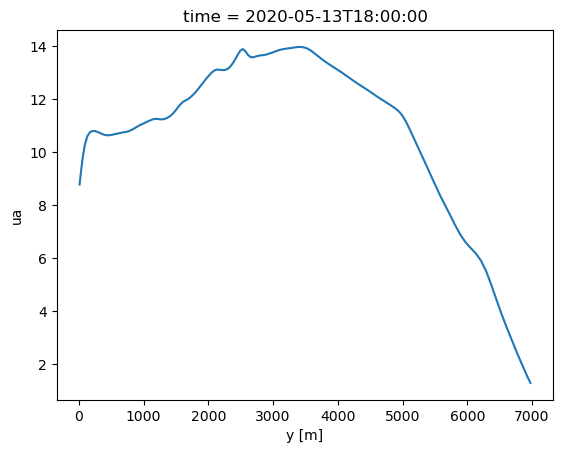

In [14]:
(dephy_check['ua'].mean(dim=['x','y'])-dharma_params['translate'].u).plot()

In [ ]:
dharma_params['translate'].v

In [15]:
qlr_3d
nlr_3d


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [2]:
rho_i = 9.e2                       # general density of ice used here, kg/m3
alpha = max([2.2e4,-4.99e3-4.94e4*np.log10(iwc_s*1e3)])
mass_s = np.pi*4.*rho_i/alpha**3   # kg (based on distribution, half of value used in code as 'typical')
num_s = iwc_s/mass_s               # m-3 total and m-4 leading constant
N_icef(ix,iy,iz) = num_s*1e-3      # m-3*1e-3 --> L-1
num_lrg_s = num_s*(1 - igamma(5,alpha*d_thresh)/gamma(5))  # m-3
N_100_ice(ix,iy,iz) = N_100_ice(ix,iy,iz) + num_lrg_s*1e-3 # L-1
area_s = np.pi/4*num_s*720/(alpha**2*24.)                  # m2/m3
R2_ice(ix,iy,iz) = R2_ice(ix,iy,iz) + area_s*1e9/np.pi     # m2/m3 --> um2/L

z_s = num_s*gamma(8)/alpha**6*f_refr*1e18 # mm6/m3
vz_s = z_s*vel_s*(0.3/rhobar(iz))**0.5    # mm6/m3 * m/s estimated


SyntaxError: cannot assign to function call here. Maybe you meant '==' instead of '='? (2902631765.py, line 5)

In [1]:
ng_ice = 3
do_rain = True
do_morr = True


nd_thresh = 1e-9
ni_thresh = 1e-12

## rewrite to gather from dharma.cdf
use_s08_gamr = 0
use_s08_limr = 0
disp_type = 0
droplet_con = 20.0
droplet_sig = 1.2
is_qr = 1


varnames = ['w','LWC','RWC','Nr','mu_r','Nwr','Dmr','D0r','Dmtr','lamr',$
            'dBZ','dBZr','DopV', 'DopVr','PR','PRr']
varnames = ['Nr','Dmtr','lamr']
    
vname      = [ 'w', moisture, 'qc' ]
i_w        = 0
i_moisture = 1
i_qc       = 2
i_last     = i_qc

vname  = [ vname, 'qic', 'qif', 'qid' ]
i_qic  = i_last + 1
i_qif  = i_last + 2
i_qid  = i_last + 3
i_last = i_last + 3

vname  = [ vname, 'qr' ]
i_qr   = i_last + 1
i_last = i_last + 1

vname = [ vname, 'nc', 'nr', 'nic', 'nif', 'nid' ]
i_nc  = i_last + 1
i_nr  = i_last + 2
i_nic = i_last + 3
i_nif = i_last + 4
i_nid = i_last + 5


vname = [ 'qr', 'nr' ]
i_qr = 0
i_nr = 1


NameError: name 'gamma' is not defined

In [ ]:



        self.vel_param_a = {'cl': 3e7, 'ci': 700., 'pl': 841.997, 'pi': 11.72}
        self.vel_param_b = {'cl': 2. * ureg.dimensionless,
                            'ci': 1. * ureg.dimensionless,
                            'pl': 0.8 * ureg.dimensionless,
                            'pi': 0.41 * ureg.dimensionless}
        
        v_tmp = model.vel_param_a[hyd_type] * p_diam ** model.vel_param_b[hyd_type]